### Importing all the required Libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the dataset into Dataframe

In [3]:
cars = pd.read_csv("/home/utkarsh/Documents/MF/Datasets/Car details v3.csv")
cars_final_num = cars.select_dtypes(['number'])
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


### Size of the dataset

In [4]:
shape = cars.shape
print(f"There are \033[1m {shape[0]} rows/patterns \033[0m and \033[1m{shape[1]} features\033[0m.")

There are  8128 rows/patterns  and 13 features.


### Feature Engineering

In [5]:
# We compute age of car and store it in the age columns
cars["age"] = 2022 - cars.year

# We encode the owner categories in the order : 'Test Drive Car' > 'First Owner' > 'Second Owner' > 'Third Owner' > 'Fourth & Above Owner'
cars["owners"] = cars.owner.map({'Test Drive Car': 5, 'First Owner': 4, 'Second Owner': 3, 'Third Owner': 2, 'Fourth & Above Owner': 1})

# Encoding Transmission values
cars["transmission_manual"] = cars.transmission.map({'Manual': 1, 'Automatic': 0})
cars["transmission_automatic"] = cars.transmission.map({'Manual': 0, 'Automatic': 1})

# Encoding Fuel values
cars["fuel_petrol"] = cars.fuel.map({'Diesel': 0, 'Petrol': 1, 'LPG': 0, 'CNG': 0})
cars["fuel_diesel"] = cars.fuel.map({'Diesel': 1, 'Petrol': 0, 'LPG': 0, 'CNG': 0})
cars["fuel_lpg"] = cars.fuel.map({'Diesel': 0, 'Petrol': 0, 'LPG': 1, 'CNG': 0})
cars["fuel_cng"] = cars.fuel.map({'Diesel': 0, 'Petrol': 0, 'LPG': 0, 'CNG': 1})

# Encoding Seller Information in the order: 'Individual' < 'Dealer' < 'Trustmark Dealer'
cars["seller"] = cars.seller_type.map({'Trustmark Dealer': 3, 'Dealer': 2, 'Individual': 1})

# Dropping missing values as they are not significant and are very few. They are due to a data collection error.
cars = cars.dropna()

# We drop columns 'name', 'mileage', 'engine', 'max_power', 'torque' as their information cannot be captured by the regression model directly. They could be grouped and added to the analysis but that is out of the scope of this project.

# We wish to predict the values of selling_price based on all the other values
cars_final = cars[['age', 'km_driven', 'owners','seats',  'transmission_manual',
       'transmission_automatic', 'fuel_petrol', 'fuel_diesel', 'fuel_lpg',
       'fuel_cng', 'seller', 'selling_price']]

### Displayed New Dataframe

In [6]:
cars_final.head()

,age,km_driven,owners,seats,transmission_manual,transmission_automatic,fuel_petrol,fuel_diesel,fuel_lpg,fuel_cng,seller,selling_price
0,8,145500,4,5.0,1,0,0,1,0,0,1,450000
1,8,120000,3,5.0,1,0,0,1,0,0,1,370000
2,16,140000,2,5.0,1,0,1,0,0,0,1,158000
3,12,127000,4,5.0,1,0,0,1,0,0,1,225000
4,15,120000,4,5.0,1,0,1,0,0,0,1,130000


In [7]:
cars_final['selling_price'].min()

29999

In [8]:
cars['selling_price'].min()

29999

### Exploratory Data Analysis

#### Type of Owner and Number of Cars

In [9]:
cars['owner'].value_counts()

First Owner             5215
Second Owner            2016
Third Owner              510
Fourth & Above Owner     160
Test Drive Car             5
Name: owner, dtype: int64

### Countplot
#### Owner Type Vs Number of Cars

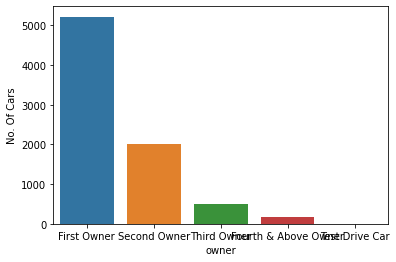

In [10]:
sns.countplot(x ='owner', data = cars).set_ylabel("No. Of Cars", fontsize = 10)
sns.set(rc = {'figure.figsize':(14,10)})

### Observation
**First Owned Cars** are **highest among all**.

### Pie Chart
#### Type of Owner Vs Number of cars.

([<matplotlib.patches.Wedge at 0x7ff4751e6b80>,
 [Text(-0.5287948494819255, 0.9645600070298312, 'First Owner'),
  Text(0.2542602127147971, -1.0702110746157631, 'Second Owner'),
  Text(1.0392884276407395, -0.36038807440319065, 'Third Owner'),
  Text(1.0974911079478653, -0.07425138365961592, 'Fourth & Above Owner'),
  Text(1.0999978287749954, -0.002185564068161089, 'Test Drive Car')],
 [Text(-0.2884335542628684, 0.5261236401980897, '65.96'),
  Text(0.13868738875352565, -0.5837514952449616, '25.50'),
  Text(0.5668845968949487, -0.19657531331083125, '6.45'),
  Text(0.5986315134261082, -0.04050075472342687, '2.02'),
  Text(0.599998815695452, -0.0011921258553605938, '0.06')])

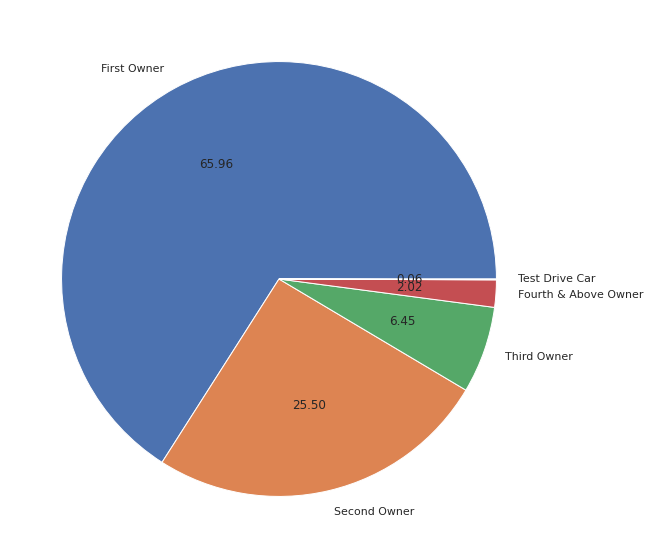

In [11]:
plt.pie(cars['owner'].value_counts(),labels=cars['owner'].unique(),autopct='%.2f')

### Observation

1. **65.96 %** of cars are **First Owned**.
2. **25.50 %** of cars are **Second Owned**.
3. **6.45 %** of cars are **Third Owned**.
4. **2.02 %** of cars are **Fourth and Above Owned**.
5. **0.06 %** of cars are **Test Drive Cars**.

### Barplot
#### Owner Vs Selling Price

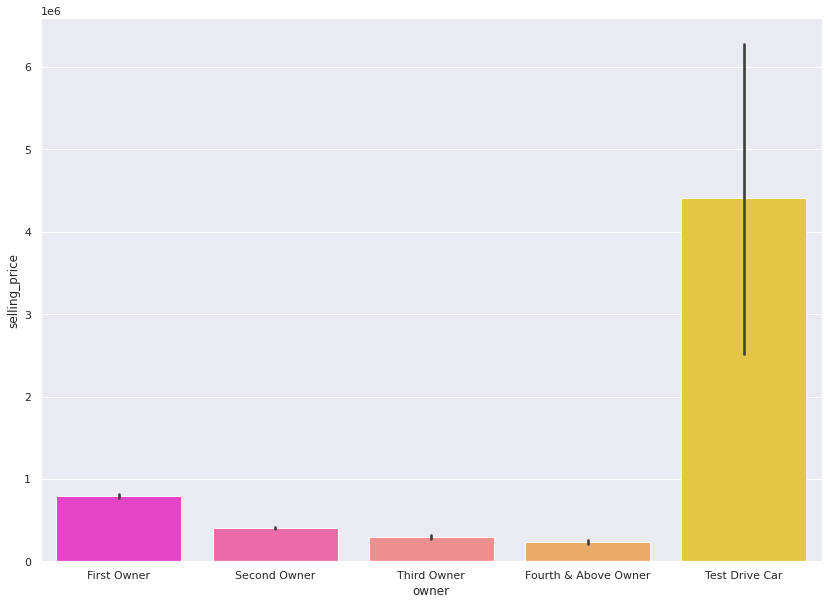

In [12]:
sns.barplot(x='owner',y='selling_price',data=cars,palette='spring')
sns.set(rc = {'figure.figsize':(10,10)})

### Observation
**Test Drive cars** have **high average selling price**. 

As **number of owners** increases the **selling price** of car **decreases**.

In [13]:
trans_cars = cars['transmission'].value_counts()

print(f"There are \033[1m {trans_cars[0]} Manual Cars\033[0m and \033[1m {trans_cars[1]} Automatic Cars\033[0m.")

There are  6865 Manual Cars and  1041 Automatic Cars.


### Countplot
#### Transmission Vs Number of Cars

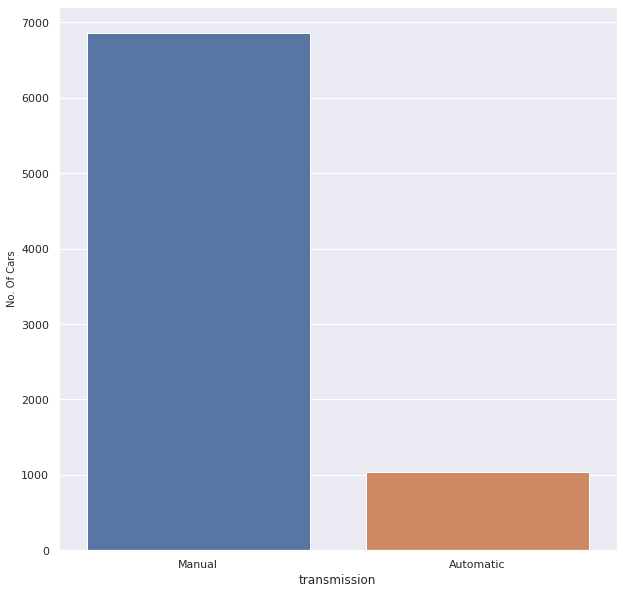

In [14]:
sns.countplot(x ='transmission', data = cars).set_ylabel("No. Of Cars", fontsize = 10)
sns.set(rc = {'figure.figsize':(10,10)})

### Observation

Most of the cars are Manual.

### Barplot
#### Transmission Vs Selling Price

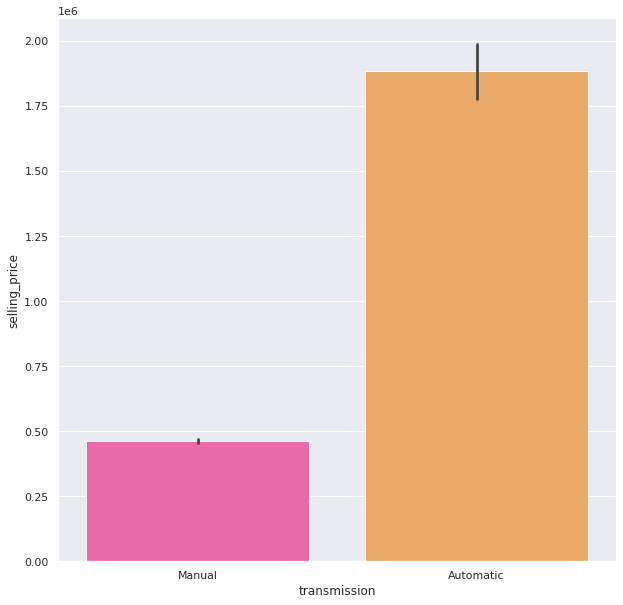

In [15]:
sns.barplot(x='transmission',y='selling_price',data=cars,palette='spring')
sns.set(rc = {'figure.figsize':(10,10)})

### Observation
Cars having **Automatic Transmission have high selling price**.

### Countplot
#### Fuel Vs Number of Cars

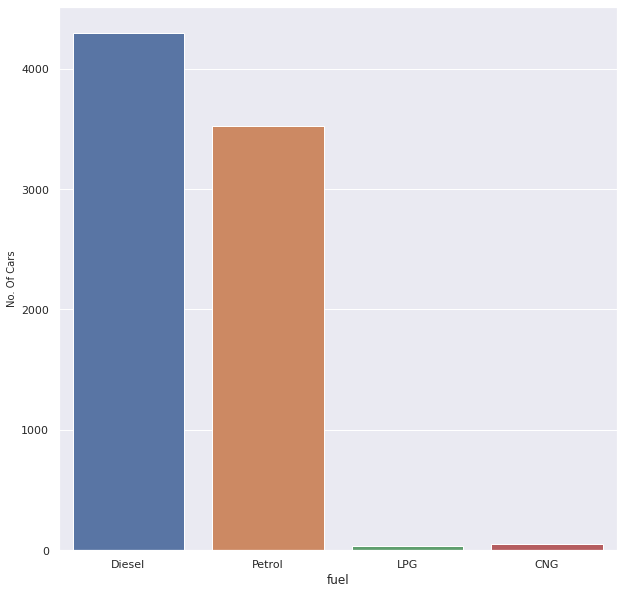

In [16]:
sns.countplot(x ='fuel', data = cars).set_ylabel("No. Of Cars", fontsize = 10)
sns.set(rc = {'figure.figsize':(10,10)})

### Observation

Most of the cars are **Diesel**.

### Barplot
#### Fuel Vs Selling Price

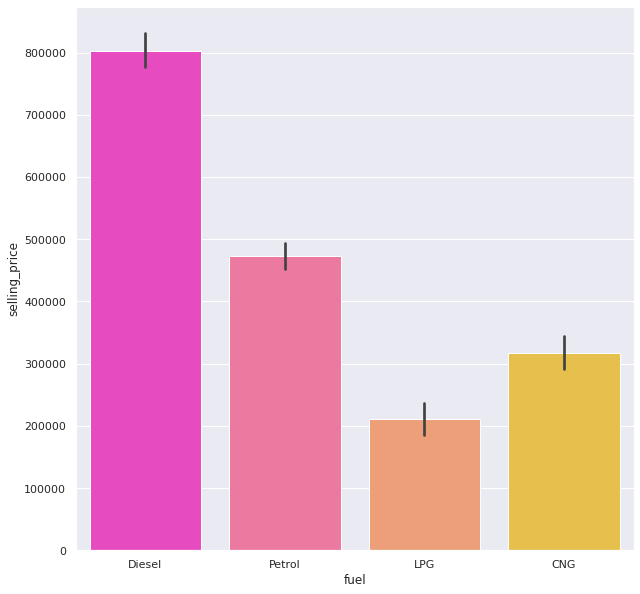

In [17]:
sns.barplot(x='fuel',y='selling_price',data=cars,palette='spring')
sns.set(rc = {'figure.figsize':(10,10)})

### Observation
**Diesel cars** have **high average selling price**.

### Countplot

#### Number of cars sold per year.

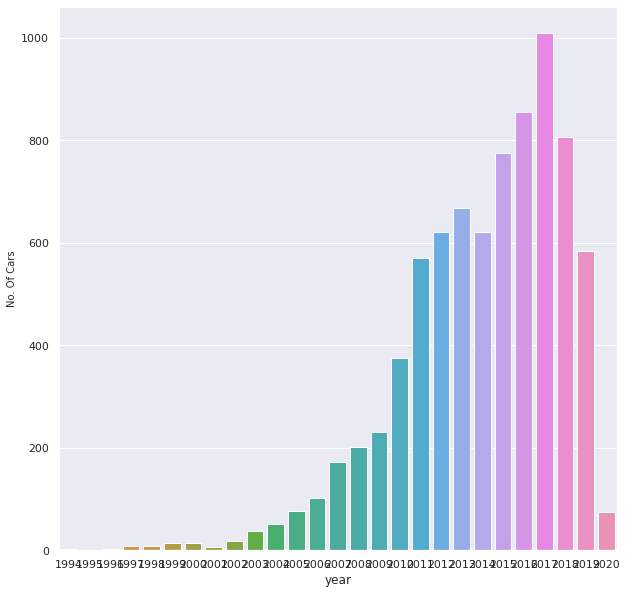

In [18]:
sns.countplot(x ='year', data = cars).set_ylabel("No. Of Cars", fontsize = 10)
sns.set(rc = {'figure.figsize':(20,10)})

### Observation

Most of the cars were sold in the year **2017**.

### Scatter plot
#### Plotting Selling Price vs Km Driven

<Figure size 720x720 with 0 Axes>

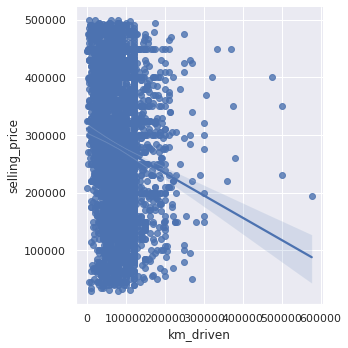

In [19]:
cars = cars[cars['selling_price'] < 500000]
plt.figure(figsize=(10,10))
sns.lmplot(x='km_driven',y='selling_price',data=cars)

### Observation

Regression line shows us the trend that,
As Kilometers driven increases Selling price of the vehicle drops sharply.

### Regression plot
#### Age Vs Selling Price

<AxesSubplot:xlabel='age', ylabel='selling_price'>

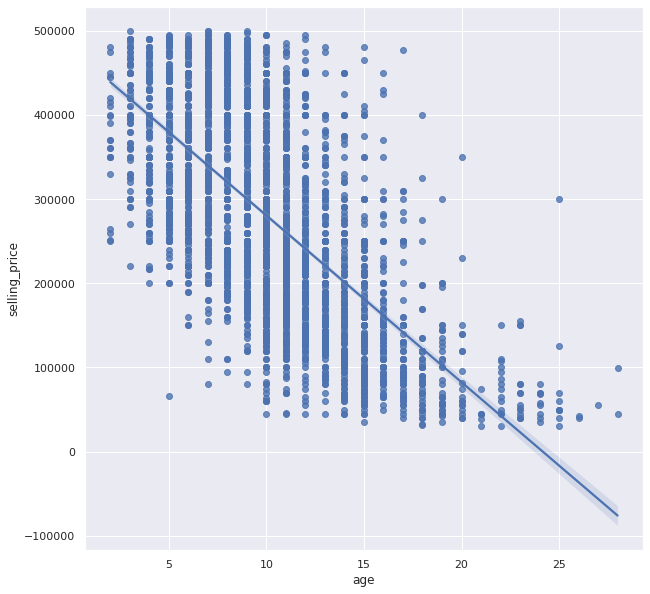

In [20]:
plt.figure(figsize=(10,10))
sns.regplot(x='age',y='selling_price',data=cars)

It seems the **selling price decreases** overall for **older/ageing vehicles**.

### Regression plot
#### Owner Vs Selling Price

<AxesSubplot:xlabel='owners', ylabel='selling_price'>

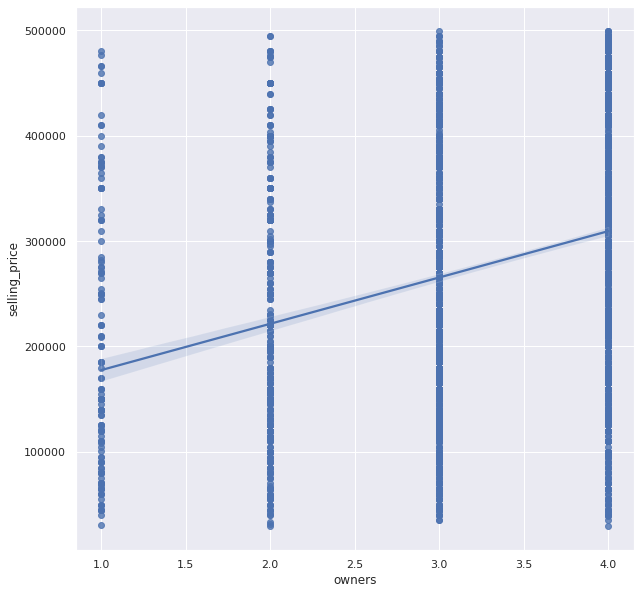

In [21]:
plt.figure(figsize=(10,10))
sns.regplot(x='owners',y='selling_price',data=cars)

The regression line shows that, **Selling price decreases as number of owner increase**.
Test drive cars have higest selling price.

### Regression plot
#### Seats Vs Selling Price

<AxesSubplot:xlabel='seats', ylabel='selling_price'>

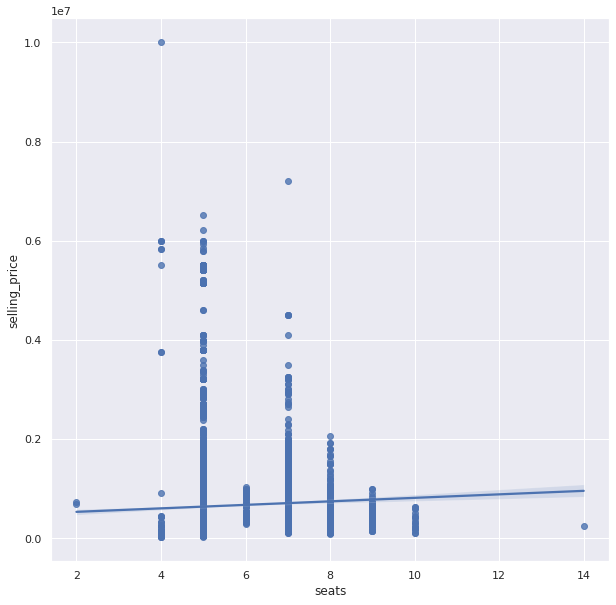

In [22]:
plt.figure(figsize=(10,10))
sns.regplot(x='seats',y='selling_price',data=cars_final)

### Correlation Matrix

In [23]:
correlations = cars_final_num.corr()
correlations

,year,selling_price,km_driven,seats
year,1.000000,0.414092,-0.418006,-0.009144
selling_price,0.414092,1.000000,-0.225534,0.041358
km_driven,-0.418006,-0.225534,1.000000,0.227336
seats,-0.009144,0.041358,0.227336,1.000000


### Plot Correlations Matrix

<AxesSubplot:>

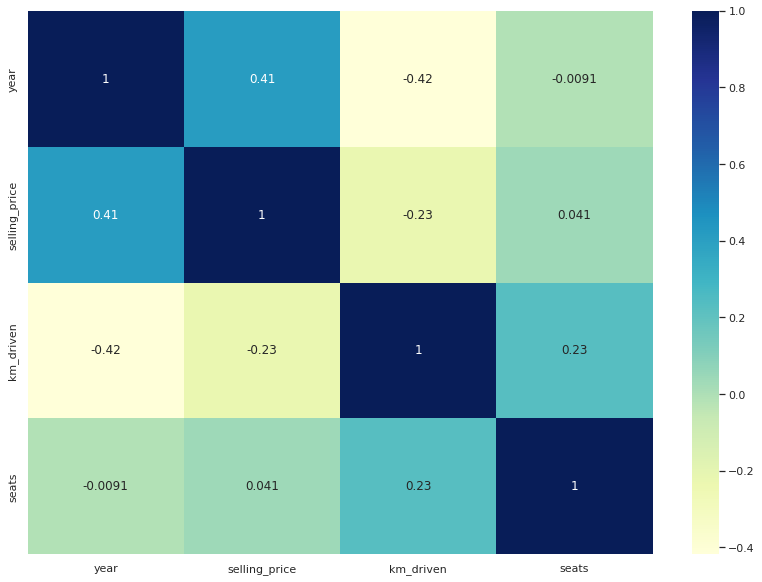

In [24]:
indx=correlations.index
plt.figure(figsize=(14,10))
sns.heatmap(cars_final_num[indx].corr(),annot=True,cmap="YlGnBu")

### Setting Data for fitting model

In [25]:
X = cars_final.drop(['selling_price','seats'],axis=1)
y = cars_final['selling_price']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Fitting various models

#### Defining functions to check Accuracy

In [27]:
def format_float(num):
    return np.format_float_positional(num, trim='-')

In [28]:
def check_accuracy(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)   
    r2 = r2_score(y_test,y_pred)
    
    dict_ = {
        "Mean Absolute Error":[format_float(mae)],
        "Mean Squared Error":[(mse)],
        "Root Mean Squred Error":[(rmse)],
        "R-Squred":[(r2)]
    }

    results = pd.DataFrame(dict_)
    results.index = ["Values"]
    
    return results

### Linear Regression

In [29]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [30]:
check_accuracy(y_test,y_pred).T

,Values
Mean Absolute Error,312846.6580468712
Mean Squared Error,346810591136.283081
Root Mean Squred Error,588906.266851
R-Squred,0.483315


### Ridge Regression 

In [31]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

y_pred = ridgeCV.predict(X_test)

print(ridgeCV.alpha_)

5.0


In [32]:
check_accuracy(y_test,y_pred).T

,Values
Mean Absolute Error,312739.00035821344
Mean Squared Error,346847159105.406982
Root Mean Squred Error,588937.313392
R-Squred,0.48326


### Lasso Regression

In [33]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

lassoCV = LassoCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

y_pred = lassoCV.predict(X_test)

print(lassoCV.alpha_)

15.0


In [34]:
check_accuracy(y_test,y_pred).T

,Values
Mean Absolute Error,312847.3744737704
Mean Squared Error,346813442825.774902
Root Mean Squred Error,588908.68802
R-Squred,0.48331


### Ploynomial Regression

In [35]:
def ploy_fit(degree, X_train, X_test, y_train):
    poly = PolynomialFeatures(degree)
    x_poly_train = poly.fit_transform(X_train)
    x_poly_test = poly.transform(X_test)

    #fitting model 
    model = LinearRegression()
    model.fit(x_poly_train,y_train)

    #predicting values
    y_pred = model.predict(x_poly_test)
    
    return y_pred  

In [36]:
how_many_poly = int(input("Enter How many degree ploynomial you want to fit?\nAnswer:"))

degree = []

for i in range(how_many_poly):
    degree.append(ploy_fit(i+1, X_train, X_test, y_train))

Enter How many degree ploynomial you want to fit?
Answer:3


In [37]:
table = []
for i in range(how_many_poly): 
    print(f"\n\033[1mDegree {i+1}\033[0m\n")
    table.append(check_accuracy(y_test,degree[i]))
    print(tabulate(table[i].T, headers=['Parameters','Values'], tablefmt='psql'))


Degree 1

+------------------------+------------------+
| Parameters             |           Values |
|------------------------+------------------|
| Mean Absolute Error    | 312847           |
| Mean Squared Error     |      3.46811e+11 |
| Root Mean Squred Error | 588906           |
| R-Squred               |      0.483315    |
+------------------------+------------------+

Degree 2

+------------------------+------------------+
| Parameters             |           Values |
|------------------------+------------------|
| Mean Absolute Error    | 253111           |
| Mean Squared Error     |      2.45435e+11 |
| Root Mean Squred Error | 495414           |
| R-Squred               |      0.634345    |
+------------------------+------------------+

Degree 3

+------------------------+------------------+
| Parameters             |           Values |
|------------------------+------------------|
| Mean Absolute Error    | 401039           |
| Mean Squared Error     |      1.30281e+13 |
|

### Making a pickel file for Streamlit

In [38]:
def code_(cars):
    cars["age"] = 2022 - cars.year

    cars["owners"] = cars.owner.map({'Test Drive Car': 5, 'First Owner': 4, 'Second Owner': 3, 'Third Owner': 2, 'Fourth & Above Owner': 1})

    cars["transmission_manual"] = cars.transmission.map({'Manual': 1, 'Automatic': 0})
    cars["transmission_automatic"] = cars.transmission.map({'Manual': 0, 'Automatic': 1})

    cars["fuel_petrol"] = cars.fuel.map({'Diesel': 0, 'Petrol': 1, 'LPG': 0, 'CNG': 0})
    cars["fuel_diesel"] = cars.fuel.map({'Diesel': 1, 'Petrol': 0, 'LPG': 0, 'CNG': 0})
    cars["fuel_lpg"] = cars.fuel.map({'Diesel': 0, 'Petrol': 0, 'LPG': 1, 'CNG': 0})
    cars["fuel_cng"] = cars.fuel.map({'Diesel': 0, 'Petrol': 0, 'LPG': 0, 'CNG': 1})

    cars["seller"] = cars.seller_type.map({'Trustmark Dealer': 3, 'Dealer': 2, 'Individual': 1})
    
    cars_final = cars[['age', 'km_driven', 'owners',  'transmission_manual',
       'transmission_automatic', 'fuel_petrol', 'fuel_diesel', 'fuel_lpg',
       'fuel_cng', 'seller']]
    
    return cars_final

In [39]:
data = {"lr": lr,"ridge":ridgeCV,"lasso":lassoCV}
with open('saved_model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [40]:
with open('saved_model.pkl', 'rb') as file:
    data = pickle.load(file)

lr_loaded = data["lr"]
ridge_loaded = data["ridge"]
lasso_loaded = data["lasso"]
#code_loaded = data["code"]

In [41]:
p = np.array([8,1000,1,1,0,0,1,0,0,2]).reshape(1, -1)
lr.predict(p)

array([821084.32606818])

In [42]:
p = np.array([8,1000,1,1,0,0,1,0,0,2]).reshape(1, -1)
print(lr_loaded.predict(p))
print(ridge_loaded.predict(p))
print(lasso_loaded.predict(p))

[821084.32606818]
[821806.40175524]
[821152.09041703]


In [43]:
year = 2019
km_driven = 145500
owner = "Test Drive Car"
transmission = "Manual"
fuel = "Diesel"
seller_type = "Dealer"

dict_ = {
        "year":[year],
        "km_driven":[km_driven],
        "owner":[owner],
        #"seats":[seats],
        "transmission":[transmission],
        "fuel":[fuel],
        "seller_type":[seller_type]
    }

results = pd.DataFrame(dict_)
#results.index = ["Values"]
results.head()

,year,km_driven,owner,transmission,fuel,seller_type
0,2019,145500,Test Drive Car,Manual,Diesel,Dealer


In [44]:
p = code_(results)
p

,age,km_driven,owners,transmission_manual,transmission_automatic,fuel_petrol,fuel_diesel,fuel_lpg,fuel_cng,seller
0,3,145500,5,1,0,0,1,0,0,2


In [45]:
p = code_loaded(results)
p

NameError: name 'code_loaded' is not defined

In [ ]:
print(lr_loaded.predict(p))